In [1]:
from simtk import openmm
from simtk import unit

import numpy as np
from sys import stdout
from openmmtools import integrators
import random
import matplotlib.pyplot as plt
import mdtraj as md
import pickle
from itertools import chain

In [2]:
def find_stride(fname, top_file, fpath_stub):

    if 'coupled' in fname:
        traj = md.load(f'Coupled_scheme/Trajectories/{fname}.dcd',top=top_file)
    else:
        traj = md.load(f'{fpath_stub}/Trajectories/{fname}.dcd',top=top_file)

    print(traj.n_frames/10000)
    return traj.n_frames/10000

In [3]:
def getenergybreakdown(fname, molecule):
    #function to get the energy distribution by component
    if molecule == 'pro':
        fpath_stub = 'proline'
        top_file = f'{fpath_stub}/cis_pro.pdb'
        system_file = f'{fpath_stub}/noconstraints_xmlsystem.txt'
        
    elif molecule == 'ala2':
        fpath_stub = 'Alanine_dipeptide'
        top_file = 'Alanine_dipeptide/ala2_fromURL.pdb'
        system_file = f'{fpath_stub}/ala2_noconstraints_system.txt'
    else:
        print('molecule not recognised')

    with open(f'{system_file}') as f:
        xml = f.read()
    system = openmm.XmlSerializer.deserialize(xml)

    platform = openmm.Platform.getPlatform(2)

    
        
    try:
        pickleFile = open(f'{fpath_stub}/parameters/parameters{fname}.pkl','rb')
        parametersdict = pickle.load(pickleFile)
        temperature = parametersdict['Temperature']
        collision_rate = parametersdict['Collision rate']
        timestep = parametersdict['Timestep']
    except:
        print(f'{fname} no parameters found')
        if 'coupled' and '300K' in fname:
            print('using 300K')
            temperature = 300.0 * unit.kelvin
            collision_rate = 10.0 / unit.picosecond
            timestep = 1.0 * unit.femtosecond
        elif 'coupled' in fname or '1000' in fname:
            print('using 1000K')
            temperature = 1000.0 * unit.kelvin
            collision_rate = 1.0 / unit.picosecond
            timestep = 1.0 * unit.femtosecond
        else:
            print('300K')
            temperature = 300.0 * unit.kelvin
            collision_rate = 1.0 / unit.picosecond
            timestep = 1.0 * unit.femtosecond

    # md_temperature = 1000 * unit.kelvin
    # md_collision_rate = 10 / unit.picosecond
    # md_timestep = 1.0 * unit.femtosecond

    for i, f in enumerate(system.getForces()):
        f.setForceGroup(i)
    
    if 'coupled' in fname:
        trajectory = md.load(f'Coupled_scheme/Trajectories/{fname}.dcd', top=f'{top_file}')
    else:    
        trajectory = md.load(f'{fpath_stub}/Trajectories/{fname}.dcd', top=f'{top_file}', stride=find_stride(fname, top_file, fpath_stub))

    coordinates = trajectory.xyz
    if len(coordinates) > 10000:
        coordinates = coordinates[0:10000]

    integrator = integrators.LangevinIntegrator(temperature=temperature,collision_rate=collision_rate,timestep=timestep)

    properties_dict = {}
    properties_dict["DeviceIndex"] = "3"

    pdb = openmm.app.PDBFile(f'{top_file}')
    topology = pdb.getTopology()
    
    simulation = openmm.app.Simulation(topology,system,integrator,platform,platformProperties=properties_dict)

    energies = {f.getName():np.zeros((len(coordinates))) for f in system.getForces()}

    for index, positions in enumerate(coordinates):
        simulation.context.setPositions(positions)

        for i, f in enumerate(system.getForces()):
            state = simulation.context.getState(getEnergy=True, groups={i})
            energies[f.getName()][index] = state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)

    mins = {f.getName() : energies[f.getName()].min() for f in system.getForces()}
    maxes = {f.getName() : energies[f.getName()].max() for f in system.getForces()}
    
    return energies, mins, maxes, system
    
#var = state.getPotentialEnergy()

In [6]:
def plotenergybreakdown(*fnameandlabels, molecule, ):
    #function to plot the breakdown by energy component of trajectories
    fig, axes = plt.subplots(2,3, figsize=(12,6), )
    axes= axes.reshape(-1)
    energies = {}
    mins = {}
    
    maxes = {}
    for fname,label in fnameandlabels:
        energies[fname], mins[fname], maxes[fname], system = getenergybreakdown(fname, molecule)

    upper_cut_mins = {'HarmonicBondForce':[100],
        'HarmonicAngleForce':[100],
        'PeriodicTorsionForce':[100],
        'NonbondedForce':[-40],
        'GBSAOBCForce':[-20],
        'CMMotionRemover':[0.0001]
    }
    lower_cut_maxes = {'HarmonicBondForce':[0],
        'HarmonicAngleForce':[0],
        'PeriodicTorsionForce':[60],
        'NonbondedForce':[-50],
        'GBSAOBCForce':[-80],
        'CMMotionRemover':[-0.0001]
    }

    force_plot_titles = {'HarmonicBondForce':'Harmonic Bond Energy',
        'HarmonicAngleForce':'Harmonic Angle Energy',
        'PeriodicTorsionForce':'Periodic Torsion Energy',
        'NonbondedForce':'Nonbonded Energy',
        'GBSAOBCForce':'Implicit solvation energy',
        'CMMotionRemover':'',
    }
        
    upper_cuts = {}
    lower_cuts = {}
    bins = {}
    for f in system.getForces():
        
        upper_cuts[f.getName()] = max(chain((np.percentile(energies[fname][f.getName()],98) for fname,label in fnameandlabels), upper_cut_mins[f.getName()]))
        lower_cuts[f.getName()] = min(chain((np.percentile(energies[fname][f.getName()],1) for fname,label in fnameandlabels), lower_cut_maxes[f.getName()]))
        

        # n_bins = 40
        #bins = np.linspace(mins_combined[f.getName()], maxes_combined[f.getName()], n_bins)
        if f.getName() == 'CMMotionRemover':
            n_bins = 1
        else:
            n_bins = 40

        bins[f.getName()] = np.linspace(lower_cuts[f.getName()], upper_cuts[f.getName()], n_bins)    
            
    for fname, label in fnameandlabels:
        for i,f in enumerate(system.getForces()):    
            alpha=(1-fnameandlabels.index((fname,label))/5)
            axes[i].hist(energies[fname][f.getName()], bins=bins[f.getName()], 
                range=(lower_cuts[f.getName()], upper_cuts[f.getName()]), label = f'{label}', alpha=alpha)
            axes[i].set_xlabel("Energy   [$kJ$ $mol^{-1}$]")
            axes[i].set_title(f'{force_plot_titles[f.getName()]}')
    axes[5].set_visible(False)  
    plt.tight_layout()
    axes[4].legend(bbox_to_anchor=(1.04,1), loc='upper left')
    

trans80_cis20_300K_noconstr no parameters found
using 300K
10.0
coupled_pro_300K_100psMD no parameters found
using 300K


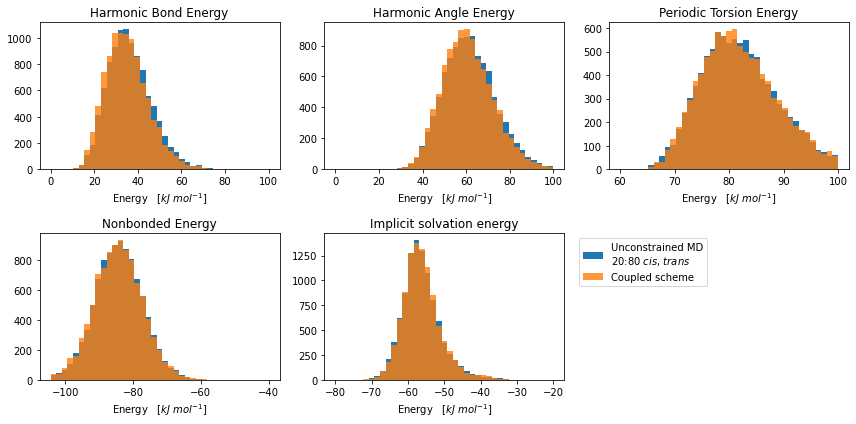

In [11]:
#example of Figure SI.3 in thesis
plotenergybreakdown(
('trans80_cis20_300K_noconstr','Unconstrained MD\n20:80 $\it{cis}$, $\it{trans}$'),
('coupled_pro_300K_100psMD', 'Coupled scheme'),
molecule='pro')